<font size="4">1.Importing the suitable libraries</font>

In [1]:
import os
import torch 
import torchvision
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import cv2
from PIL import Image
from torch.utils.tensorboard import SummaryWriter
import time

from utils import get_transform

/home/s5532166/.pyenv/versions/anaconda3-2022.05/envs/ML_Labs/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<font size="4">2.Defining some constants</font>

In [2]:
#A constant is a particular kind of variable that stores values that are fixed.

NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
BATCH_SIZE = 16
NOISE_FACTOR = 0.5

<font size="4">3.Converting the picture pixel data to PyTorch tensors and normalising the values.</font>

In [3]:
transform = get_transform()
 
#The pixel values will fall inside the range [0, 1] after being normalised. 
#Compared to the [0, 256] pixel value range, Normalize function leads to quicker training.

<font size="4">4.Downloading the MNIST_Fashion Dataset.</font>

In [4]:
#Getting ready the trainloader, testloader and validation sets for the respective training and testing.

trainset = datasets.FashionMNIST(
    root='./data',
    train=True, 
    download=True,
    transform=transform
)
testset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)
valset = datasets.FashionMNIST(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

<font size="4">5.Splitting the dataset for training, testing and validation</font>

In [5]:
#trainloader
trainloader = DataLoader(
    trainset, 
    batch_size=BATCH_SIZE,
    shuffle=True
)
#testloader
testloader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True
)
#validation
val_loader = DataLoader(
    testset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

<font size="4">6.Plotting an image from the dataset using Matplotlib</font>

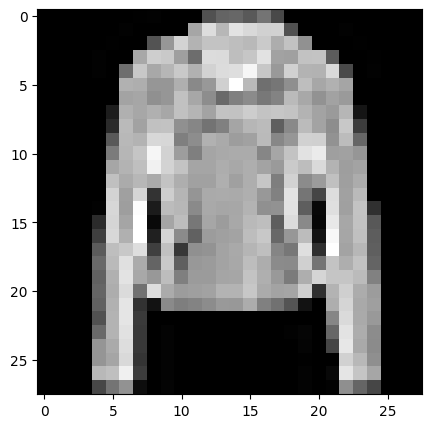

In [6]:
#Getting a batch of training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
images = images.numpy()
#Visualising a random image from the dataset.
img = np.squeeze(images[0])

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

<font size="4">7.Autoencoder network with encoder and decoder layers</font>

In [7]:
#Autoencoder
### Modified from :-
### Javier Fernandez (November 8, 2020). Autoencoder in PyTorch for the Fashion-MNIST dataset [online].
### [Accessed: January 5, 2023]. Available from - 'https://javiferfer.medium.com/autoencoder-in-pytorch-for-the-fashion-mnist-dataset-66f4fb9465b4'
### Original code is available in a txt file named as 3rd_party_code.

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder layers
        self.enc1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.enc2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.enc3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)
        self.enc4 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        
        # decoder layers
        self.dec1 = nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2)  
        self.dec2 = nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2)
        self.dec3 = nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2)
        self.dec4 = nn.ConvTranspose2d(32, 64, kernel_size=2, stride=2)
        self.out = nn.Conv2d(64, 1, kernel_size=3, padding=1)
    def forward(self, x):
        # encode
        x = F.relu(self.enc1(x))
        x = self.pool(x)
        x = F.relu(self.enc2(x))
        x = self.pool(x)
        x = F.relu(self.enc3(x))
        x = self.pool(x)
        x = F.relu(self.enc4(x))
        x = self.pool(x) # the latent space representation
        
        # decode
        x = F.relu(self.dec1(x))
        x = F.relu(self.dec2(x))
        x = F.relu(self.dec3(x))
        x = F.relu(self.dec4(x))
        x = F.sigmoid(self.out(x))
        return x
net = Autoencoder()
print(net)


Autoencoder(
  (enc1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (enc4): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dec1): ConvTranspose2d(8, 8, kernel_size=(3, 3), stride=(2, 2))
  (dec2): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
  (dec3): ConvTranspose2d(16, 32, kernel_size=(2, 2), stride=(2, 2))
  (dec4): ConvTranspose2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
  (out): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


<font size="4">8.Logging using Tensorboard</font>

In [8]:
#Logging
tb_writer = SummaryWriter()

#TensorBoard allows to plot various metrics such as loss, accuracy, and other custom metrics over time, 
#which can help in understanding the performance of the model and identify trends or patterns.

<font size="4">9.Loss function</font>

In [9]:
# the loss function
criterion = nn.MSELoss()

#The criterion loss function is used to calculate the difference between the original, clean input and the model's output. 
#This disparity, also known as the reconstruction error, is used to train the model to reduce the amount of noise in the output.

<font size="4">10.Optimizer</font>

In [10]:
# the optimizer
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

#The Adam optimizer adjusts the learning rate for each parameter depending on the historical gradient 
#and the historical gradient square, which can aid in model convergence.

<font size="4">11.Training and Validation functions</font>

In [11]:
# the training function
def train(net, trainloader, NUM_EPOCHS, writer):
#     train_loss = []
    for epoch in range(NUM_EPOCHS):
        running_loss = 0.0
        net.train()
        for data in trainloader:
            img, _ = data 
            # adding noise to the image data
            img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
            # clipping to make the values fall between 0 and 1
            img_noisy = np.clip(img_noisy, 0., 1.)
            img_noisy = img_noisy.to(device)
            optimizer.zero_grad()
            outputs = net(img_noisy)
            loss = criterion(outputs, img_noisy)
            # backpropagation
            loss.backward()
            # updating the parameters
            optimizer.step()
            running_loss += loss.item()
        
        loss = running_loss / len(trainloader)
        writer.add_scalar("Loss/train", loss, epoch)

        #Validation function
        
        net.eval()
        running_loss_val = 0.0
        with torch.no_grad():
            for img, _ in val_loader:
                # adding noise to the image data
                img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
                # clipping to make the values fall between 0 and 1
                img_noisy = np.clip(img_noisy, 0., 1.)
                img_noisy = img_noisy.to(device)
                output = net(img_noisy)
                loss = criterion(output, img_noisy)
                running_loss_val += loss.item()

        loss_epoch = running_loss_val / len(val_loader) 
        writer.add_scalar("Loss/val", loss_epoch, epoch)
        print('Epoch {} of {}, Train Loss: {:.3f}, Val Loss: {:.3f}'.format(
            epoch+1, NUM_EPOCHS, loss, loss_epoch))
        save_decoded_image(img_noisy.cpu().data, name='./Saved_Images/noisy{}.png'.format(epoch))
        save_decoded_image(outputs.cpu().data, name='./Saved_Images/denoised{}.png'.format(epoch))
    return loss_epoch

<font size="4">12.Testing function</font>

In [12]:
def test_image_reconstruction(net, testloader):
     for batch in testloader:
        img, _ = batch
        # adding noise to the image data
        img_noisy = img + NOISE_FACTOR * torch.randn(img.shape)
        # clipping to make the values fall between 0 and 1
        img_noisy = np.clip(img_noisy, 0., 1.)
        img_noisy = img_noisy.to(device)
        outputs = net(img_noisy)
        outputs = outputs.view(outputs.size(0), 1, 28, 28).cpu().data
        #saving the noisy and denoised images
        save_image(img_noisy, 'noisy_test_input.png')
        save_image(outputs, 'denoised_test_reconstruction.png')
        break

<font size="4">13.GPU selection, saving and training loop</font>

In [13]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device
def make_dir():
    image_dir = 'Saved_Images'
    if not os.path.exists(image_dir):
        os.makedirs(image_dir)
def save_decoded_image(img, name):
    img = img.view(img.size(0), 1, 28, 28)
    save_image(img, name)

In [14]:
device = get_device()
print(device)
net.to(device)
make_dir()
train_loss = train(net, trainloader, NUM_EPOCHS, tb_writer)
test_image_reconstruction(net, testloader)

cuda:0


/home/s5532166/.pyenv/versions/anaconda3-2022.05/envs/ML_Labs/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch 1 of 20, Train Loss: 0.057, Val Loss: 0.056
Epoch 2 of 20, Train Loss: 0.058, Val Loss: 0.055
Epoch 3 of 20, Train Loss: 0.060, Val Loss: 0.055
Epoch 4 of 20, Train Loss: 0.054, Val Loss: 0.055
Epoch 5 of 20, Train Loss: 0.069, Val Loss: 0.054
Epoch 6 of 20, Train Loss: 0.049, Val Loss: 0.054
Epoch 7 of 20, Train Loss: 0.046, Val Loss: 0.054
Epoch 8 of 20, Train Loss: 0.068, Val Loss: 0.054
Epoch 9 of 20, Train Loss: 0.037, Val Loss: 0.054
Epoch 10 of 20, Train Loss: 0.061, Val Loss: 0.054
Epoch 11 of 20, Train Loss: 0.053, Val Loss: 0.053
Epoch 12 of 20, Train Loss: 0.047, Val Loss: 0.053
Epoch 13 of 20, Train Loss: 0.054, Val Loss: 0.054
Epoch 14 of 20, Train Loss: 0.056, Val Loss: 0.053
Epoch 15 of 20, Train Loss: 0.057, Val Loss: 0.053
Epoch 16 of 20, Train Loss: 0.060, Val Loss: 0.053
Epoch 17 of 20, Train Loss: 0.055, Val Loss: 0.053
Epoch 18 of 20, Train Loss: 0.051, Val Loss: 0.053
Epoch 19 of 20, Train Loss: 0.050, Val Loss: 0.053
Epoch 20 of 20, Train Loss: 0.050, Val L

<font size="4">14.Plotting Noisy and Reconstructed Denoised images</font>

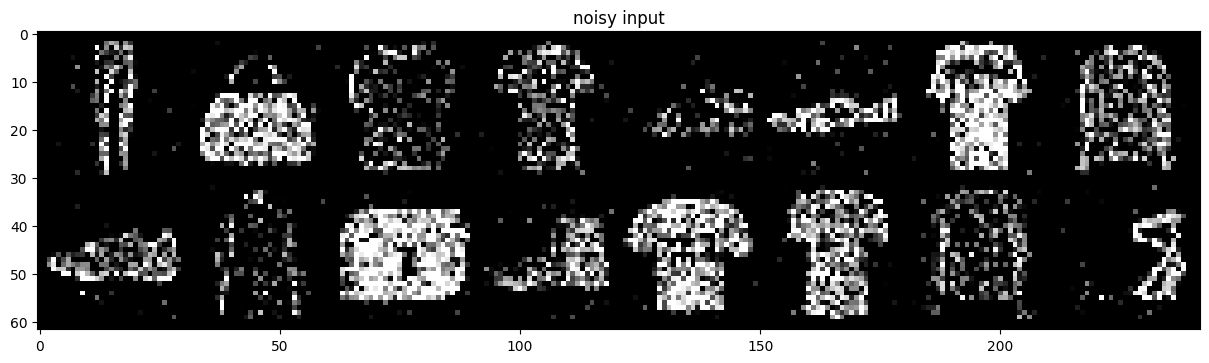

In [15]:
#Visualising noisy image saved during the training.

import matplotlib.image as mpimg

fig = plt.figure(figsize = (15,15)) 

img = mpimg.imread("noisy_test_input.png")
plt.title('noisy input')
imgplot = plt.imshow(img)
plt.show()

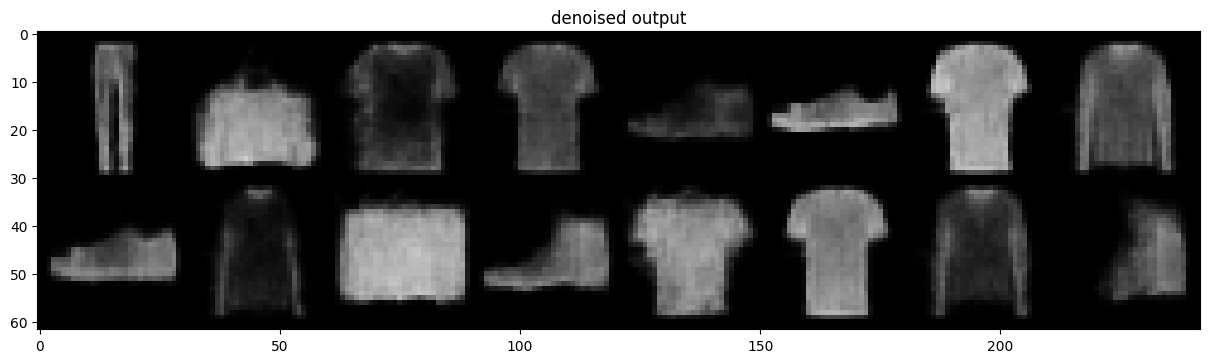

In [16]:
#Displaying the denoised image 

fig = plt.figure(figsize = (15,15)) 

img = mpimg.imread("denoised_test_reconstruction.png")
plt.title('denoised output')
imgplot = plt.imshow(img)
plt.show()

<font size="4">15.Checkpointing</font>

In [17]:
#Creating checkpoints
if (NUM_EPOCHS+1):
    checkpoint_path = "checkpoint_{}.pth".format(NUM_EPOCHS+1)
    torch.save({'NUM_EPOCHS': NUM_EPOCHS+0,
                    'model_state_dict': net.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict()},
                   checkpoint_path)


<font size="4">16.Deployment</font>

In [18]:
#Deployment(loading the model from the checkpoint)

checkpoint_path = "checkpoint_21.pth"
checkpoint = torch.load(checkpoint_path)

net.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

NUM_EPOCHS = checkpoint['NUM_EPOCHS']